# Notebook written to handle with the data, and get the first results. 
This notebook mainly focuses on Holt-Winter methods. We can notice, for the following, that neither 'mul' nor 'multiplicative' work for the Holt-Winter method. However, this multiplicative ways to do are more suited to our problem, given that we have high variations in our data. 

In [1]:
import os, sys
import time

import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm

In [2]:
train_filename = "Train_SU63ISt.csv"
path_to_file = f"DATA/{train_filename}"
data = pd.read_csv(path_to_file, usecols=[1, 2], engine="python")

In [3]:
data['Date'] = pd.to_datetime(data['Datetime'])
data.index = data.Date
data = data.drop(['Datetime','Date'], axis=1)

In [4]:
# Impose frequency of data to ease the next treatments
data = data.asfreq('H')
# Sort the data by dates 
data = data.sort_index()

In [5]:
data.head(10)

,Count
Date,
2012-08-25 00:00:00,8.0
2012-08-25 01:00:00,2.0
2012-08-25 02:00:00,6.0
2012-08-25 03:00:00,2.0
2012-08-25 04:00:00,2.0
2012-08-25 05:00:00,2.0
2012-08-25 06:00:00,2.0
2012-08-25 07:00:00,2.0
2012-08-25 08:00:00,6.0


# Handle 'Nan' values which would polute the predictions made by our models

In [6]:
### Missing values (NaN) in train data 
# Counting cells with missing values 
train_missing_cells = sum(data.isnull().values.ravel())
#Counting rows that have missing values somewhere 
train_missing_lines = sum(data.apply(lambda x: sum(x.isnull().values), axis = 1)>0)
print('In train data, there are %s NaN cells, among %s lines' %(train_missing_cells, train_missing_lines))

count = 0
for i in range(data.shape[0]):
    if (np.isnan(data.Count.iloc[i])):
        count += 1
        data.Count.iloc[i] = data.Count.iloc[i-1]
print(count)

# Counting cells with missing values 
train_missing_cells = sum(data.isnull().values.ravel())
#Counting rows that have missing values somewhere 
train_missing_lines = sum(data.apply(lambda x: sum(x.isnull().values), axis = 1)>0)
print('In train data, there are %s NaN cells, among %s lines' %(train_missing_cells, train_missing_lines))

In train data, there are 1416 NaN cells, among 1416 lines
1416
In train data, there are 0 NaN cells, among 0 lines


# Split training and testing data 

In [7]:
train = data[:int(data.shape[0]*0.4)]
test = data[int(data.shape[0]*0.4):int(data.shape[0]*0.5)]

print('Train starts at %s and ends at %s' %(train.index.min(),train.index.max()))
print('Test starts at %s and ends at %s' %(test.index.min(),test.index.max()))

Train starts at 2012-08-25 00:00:00 and ends at 2013-06-25 18:00:00
Test starts at 2013-06-25 19:00:00 and ends at 2013-09-09 23:00:00


In [8]:
train.index.freq

<Hour>

In [9]:
train.head()

,Count
Date,
2012-08-25 00:00:00,8.0
2012-08-25 01:00:00,2.0
2012-08-25 02:00:00,6.0
2012-08-25 03:00:00,2.0
2012-08-25 04:00:00,2.0


In [10]:
train.tail()

,Count
Date,
2013-06-25 14:00:00,98.0
2013-06-25 15:00:00,98.0
2013-06-25 16:00:00,128.0
2013-06-25 17:00:00,112.0
2013-06-25 18:00:00,124.0


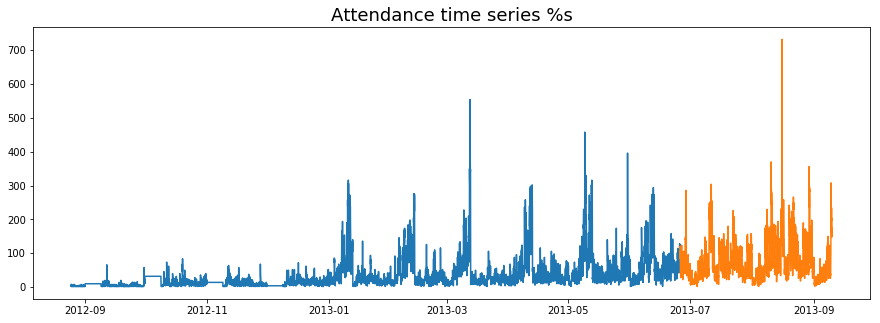

In [11]:
### Observe the data and get an idea of what we are dealing with
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(train.index, train.Count)
ax.plot(test.index, test.Count)
title= 'Attendance time series %s'
ax.set_title(title,fontsize=18)
#fig.savefig('sales_time_series.png', bbox_inches='tight')
plt.show()

# HOLT-WINTER MODEL : a first step towards prediction 

In [12]:
v = pd.DataFrame(data=np.array([4,2,3,np.NaN,8]))
mean_squared_error(v.values[v.notna().values], np.array([2,2,2,2]))

10.25

In [13]:
train.shape

(7315, 1)

In [14]:
# Quickly check that there is no missing date : check that our dataset has a coherent number of lines
pd.date_range(start=str(train.index.min()), end=str(train.index.max()), freq='60min')

DatetimeIndex(['2012-08-25 00:00:00', '2012-08-25 01:00:00',
               '2012-08-25 02:00:00', '2012-08-25 03:00:00',
               '2012-08-25 04:00:00', '2012-08-25 05:00:00',
               '2012-08-25 06:00:00', '2012-08-25 07:00:00',
               '2012-08-25 08:00:00', '2012-08-25 09:00:00',
               ...
               '2013-06-25 09:00:00', '2013-06-25 10:00:00',
               '2013-06-25 11:00:00', '2013-06-25 12:00:00',
               '2013-06-25 13:00:00', '2013-06-25 14:00:00',
               '2013-06-25 15:00:00', '2013-06-25 16:00:00',
               '2013-06-25 17:00:00', '2013-06-25 18:00:00'],
              dtype='datetime64[ns]', length=7315, freq='60T')

In [15]:
### Test the seasonality which seems to be the most appropriated : this run is very long 

y_hat_avg = test.copy()
rmse_scores = []
P = 30
periods = np.arange(2,P)

testing = False

if testing:
    for p in periods:
        fitted = ExponentialSmoothing(train['Count'].values, seasonal_periods=p ,trend='add', seasonal='add').fit()
        forcasted = fitted.forecast(len(test))
        forcasted = forcasted.reshape(forcasted.shape[0],1)
        filterNa = pd.DataFrame(data=forcasted).notna().values
        if (len(test.Count.values[filterNa[:,0]]) > 2):
            rms = sqrt(mean_squared_error(test.Count.values[filterNa[:,0]], forcasted[filterNa[:,0]]))
        else:
            rms = 1e5
        rmse_scores.append(rms)

        if (p < (P-1)):
            sys.stdout.write('Seasonal period : %s ; RMS : %s\r' %(p,rms))
            sys.stdout.flush()   
        else:
            print('Seasonal period : %s ; RMS : %s\r' %(p,rms))

    print('Min for seasonal period : %s' %(np.argmin(rmse_scores)+2))

In [16]:
if testing:
    #Plotting data
    fig,ax = plt.subplots(figsize=(15,5))
    ax.plot(periods, rmse_scores)

    title= "RMSE score for Holt-Winter (trend='add' & seasonal='add')"
    ax.set_title(title,fontsize=18)
    fig.savefig('rmse_holt_winter.png', bbox_inches='tight')
    plt.show()

The minimum is reach for seasonal = 24 : there are 24 measurements per day, this is coherent. 

In [17]:
# Build and predict with a model which has a seasonality 24
fitted = ExponentialSmoothing(train['Count'].values, seasonal_periods=24 ,trend='add', seasonal='add').fit()
forcasted = fitted.forecast(len(test))
forcasted = forcasted.reshape(forcasted.shape[0],1)
filterNa = pd.DataFrame(data=forcasted).notna().values
if (len(test.Count.values[filterNa[:,0]]) > 2):
    print("RMSE can be calculated")
    rms_holt = sqrt(mean_squared_error(test.Count.values[filterNa[:,0]], forcasted[filterNa[:,0]]))
else:
    print("RMSE can't be calculated")

RMSE can be calculated


In [18]:
print(rms_holt)

70.87456174122413


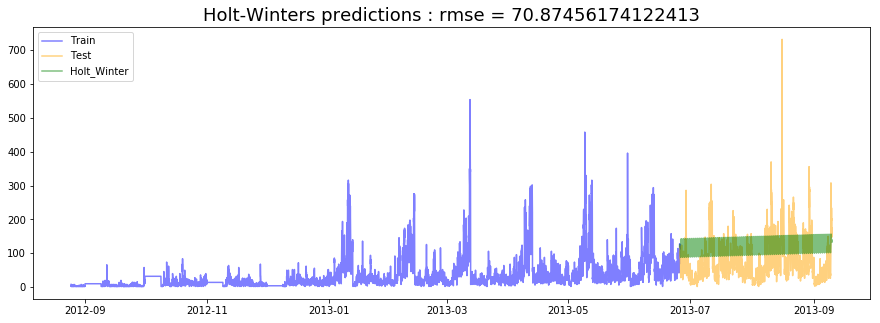

In [19]:
# Plotting 
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(train['Count'], label='Train', c='b', alpha=0.5)
ax.plot(test['Count'], label='Test', c='orange', alpha=0.5)
ax.plot(test.index.values,forcasted, label='Holt_Winter', c='green', alpha=0.5)
plt.legend(loc='best')
title = "Holt-Winters predictions : rmse = %s" %(rms_holt)
ax.set_title(title, fontsize=18)
plt.show()
fig.savefig('holt_winter.png', bbox_inches='tight')

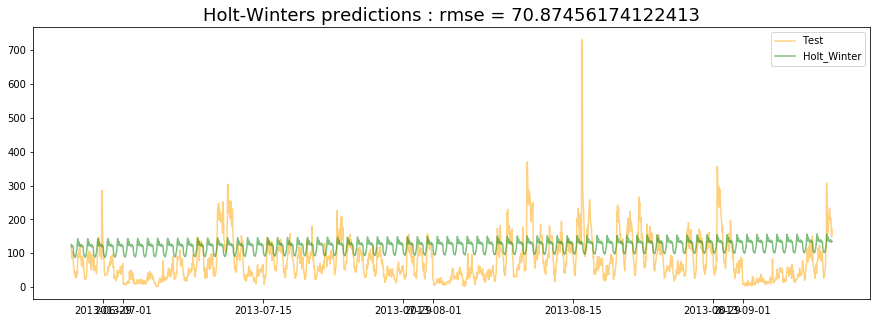

In [20]:
# Plotting test only 
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(test['Count'], label='Test', c='orange', alpha=0.5)
ax.plot(test.index.values,forcasted, label='Holt_Winter', c='green', alpha=0.5)
plt.legend(loc='best')
title = "Holt-Winters predictions : rmse = %s" %(rms_holt)
ax.set_title(title, fontsize=18)
plt.show()
fig.savefig('holt_winter_test.png', bbox_inches='tight')

# ARMA-ARIMA : not handled yet

In this section, we will test different parameter values for the ARMA-ARIMA model implemented in Python. For the seasonality, we take 24, as previously. The idea here is to set up the different integration orders. 

In [12]:
# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from sklearn.externals.joblib import Parallel
from sklearn.externals.joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

## Grid searching for our model hyperparameters 
Source : https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

In [13]:
# Perform a prediction with the SARIMAX model
# Parameters : 
#     - traindata : the training dataset 
#     - config : the configuration, specifying three parameters for SARIMAX prediction 
#                (order, sorder, trend)
#     - prediction_start_date : the date from which start to predict 
#     - prediction_end_date : the date until which to predict 
# Return : 
#   - the desired SARIMAX model, able to predict a time series based on the training data

def sarima_forecast(traindata, config, prediction_start_date, prediction_end_date):
    # Get the configuration with which to learn 
    order, sorder, trend = config
    # Define the model 
    model = SARIMAX(traindata, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # Train the model 
    model_fit = model.fit(disp=False)
    # Make the prediction 
    yhat = model_fit.predict(start=prediction_start_date, end=prediction_end_date, dynamic=True)
    return yhat

In [58]:
# Return the Root Mean Squarred Error between to series 
# Parameters : 
#     - actual : the observations 
#     - predicted : the predictions 
# Return : 
#     - the root mean squarred error between actual and predicted 

def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [59]:
# Split a univariate dataset into train and test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [60]:
# Make a prediction on a dataset with a SARIMAX model parametered with the configuration cfg
# Parameters : 
#     - data : the whole data set
#     - n_test : the number of samples to keep for testing 
#     - cfg : the configuration to set up the model used for prediction
# Return : 
#     - the error made by the prediction performed 

def walk_forward_validation(data, n_test, cfg):
    # split dataset
    train, test = train_test_split(data, n_test)
    predictions = sarima_forecast(train, cfg, test.index.min(), test.index.max())
    error = measure_rmse(test, predictions)
    return error

In [89]:
# A wrapper for the previous function : it catches the errors, and eventually keeps computing 
# or stops in order to debug 

def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        sys.stdout.write('\r> Model[%s] %.3f' % (key, result))
        sys.stdout.flush()
    return (key, result)

In [90]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

In [91]:
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                            for D in D_params:
                                for Q in Q_params:
                                    for m in m_params:
                                        cfg = [(p,d,q), (P,D,Q,m), t]
                                        models.append(cfg)
    return models

In [92]:
data.head()

,Count
Date,
2012-08-25 00:00:00,8.0
2012-08-25 01:00:00,2.0
2012-08-25 02:00:00,6.0
2012-08-25 03:00:00,2.0
2012-08-25 04:00:00,2.0


In [93]:
print(train.index.freq)
print(train.index.inferred_freq)

<Hour>
H


In [94]:
count = 0

In [ ]:
if __name__ == '__main__':
    # define dataset
    # data split
    n_test = 20
    # model configs
    cfg_list = sarima_configs()
    # grid search
    scores = grid_search(data[:2000], cfg_list, n_test)
    # list top 3 configs
    print("\n The top 3 scoring models :")
    for cfg, error in scores[:3]:
        print(cfg, error)

> Model[[(0, 1, 0), (1, 0, 2, 0), 't']] 11.774

In [31]:
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.Count, order=(9, 1, 4),seasonal_order=(1,1,1,12)).fit(cov_type='robust', method='cg', trend='ct')

ValueError: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.

In [29]:
print(fit1.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Count   No. Observations:                 7315
Model:             SARIMAX(2, 1, 4)x(1, 1, 1, 12)   Log Likelihood              -33908.234
Date:                            Mon, 07 Jan 2019   AIC                          67834.469
Time:                                    18:44:10   BIC                          67896.532
Sample:                                08-25-2012   HQIC                         67855.809
                                     - 06-25-2013                                         
Covariance Type:                           robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3941      0.369      1.069      0.285      -0.329       1.117
ar.L2         -0.0293      0.360   

In [26]:
y_hat_avg['SARIMA'] = fit1.predict(start=prediction_start_date, end=prediction_end_date, dynamic=True)

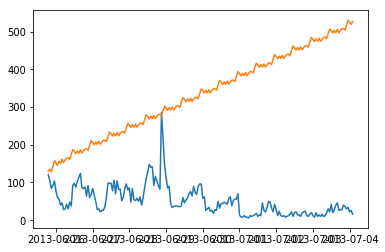

In [27]:
plt.plot(test.Count[:200])
plt.plot(y_hat_avg['SARIMA'][:200])

In [28]:
rms_arima = sqrt(mean_squared_error(test.Count[:20], y_hat_avg['SARIMA'][:20]))
print(rms_arima)

95.96402767791886
